In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
from pathlib import Path

In [2]:
from google.colab import drive
import os

# colab
drive.mount('/content/drive')

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('./drive/MyDrive/Colab Notebooks/project')

Mounted at /content/drive


# Lecture Code

In [3]:
from typing import Dict, List, Tuple, Sequence

def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    """
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Args:
        df (pd.DataFrame): Overall dataframe
        fold_length (int): How long each fold should be in rows
        fold_stride (int): How many timesteps to move forward between taking each fold

    Returns:
        List[pd.DataFrame]: A list where each fold is a dataframe within
    """
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on
    the split ratio.
    - df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    - df_test should contain all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """

    # TRAIN SET
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

def get_Xi_yi(
    fold:pd.DataFrame,
    input_length:int,
    output_length:int) -> Tuple[pd.DataFrame]:
    """given a fold, it returns one sequence (X_i, y_i) as based on the desired
    input_length and output_length with the starting point of the sequence being chosen at random based

    Args:
        fold (pd.DataFrame): A single fold
        input_length (int): How long each X_i should be
        output_length (int): How long each y_i should be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (X_i, y_i)
    """

    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][TARGET]

    return (X_i, y_i)

def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int) -> Tuple[np.array]:
    """Given a fold generate X and y based on the number of desired sequences
    of the given input_length and output_length

    Args:
        fold (pd.DataFrame): Fold dataframe
        number_of_sequences (int): The number of X_i and y_i pairs to include
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)

def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int,
    sequence_stride: int) -> Tuple[np.array]:
    """slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence

    Args:
        fold (pd.DataFrame): One single fold dataframe
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i
        sequence_stride (int): How many timesteps to take before taking the next X_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][TARGET]
        X.append(X_i)
        y.append(y_i)

    return (np.array(X), np.array(y))


# Sampling

In [ ]:
from bikesharing.params import *
# local
data = pd.read_csv(f'{LOCAL_DATA_PATH}/processed/data_for_rnn_subset_of_districts.csv')

In [50]:
# colab
X = pd.read_csv('./data/X_processed_from_2019_to_2022.csv')
y = pd.read_csv('./data/y_processed_from_2019_to_2022.csv')
data = pd.concat([X,y], axis=1).drop(columns=["Unnamed: 0"])

In [52]:
data = data.loc[:35064*0.75]

In [110]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Berg am Laim', 'Bogenhausen', 'Hadern', 'Laim',
       'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt', 'Milbertshofen-Am Hart',
       'Moosach', 'Neuhausen-Nymphenburg', 'Obergiesing',
       'Obersendling', 'Pasing', 'Pasing-Obermenzing', 'Ramersdorf-Perlach',
       'Schwabing-Freimann', 'Schwabing-West', 'Schwanthalerhöhe', 'Sendling',
       'Sendling-Westpark', 'Thalkirchen', 'Trudering',
       'Trudering-Riem', 'Untergiesing', 'Untergiesing-Harlaching',
       'Aubing-Lochhausen-Langwied', 'Harlaching', 'Südgiesing', 'Hasenbergl-Lerchenau Ost',
       'Obermenzing', 'Feldmoching', 'Untermenzing-Allach', 'Lochhausen']

In [54]:
FOLD_LENGTH = 17520
FOLD_STRIDE = 2184
TRAIN_TEST_RATIO = 0.8
INPUT_LENGTH = 336 # 24 h * 28 d
OUTPUT_LENGTH = 24
SEQUENCE_STRIDE = 1
TARGET = districts
N_TARGETS = len(districts)
N_FEATURES = 13
N_TRAIN = 8000 # number_of_sequences_train
N_TEST =  2000 # number_of_sequences_test

In [55]:
folds = get_folds(data, FOLD_LENGTH, FOLD_STRIDE)
print(f'number of folds: {len(folds)}')

number of folds: 5


In [ ]:
(fold_train, fold_test) = train_test_split(folds[0], TRAIN_TEST_RATIO, INPUT_LENGTH)

In [56]:
(fold_train, fold_test) = train_test_split(data, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [ ]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)
X_train_i

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,is_holiday,is_weekend,hour_sin,hour_cos,month_sin,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
6793,0.441501,0.909091,0.431227,0.174684,0.0,0.750000,0.933013,0.066987,0.75,0.895896,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6794,0.428256,0.922078,0.420074,0.149367,0.0,0.853553,0.853553,0.066987,0.75,0.895896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6795,0.432671,0.922078,0.423792,0.149367,0.0,0.933013,0.750000,0.066987,0.75,0.895896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6796,0.434879,0.909091,0.421933,0.189873,0.0,0.982963,0.629410,0.066987,0.75,0.895896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6797,0.406181,0.948052,0.395911,0.177215,0.0,1.000000,0.500000,0.066987,0.75,0.895896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,0.516556,0.948052,0.509294,0.210127,0.0,0.146447,0.853553,0.066987,0.75,0.005131,...,2.0,2.0,1.0,0.0,0.0,1.0,1.0,3.0,3.0,0.0
7125,0.498896,0.961039,0.490706,0.202532,0.0,0.250000,0.933013,0.066987,0.75,0.005131,...,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7126,0.492274,0.974026,0.488848,0.154430,0.0,0.370590,0.982963,0.066987,0.75,0.005131,...,0.0,4.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
7127,0.483444,0.987013,0.481413,0.149367,0.0,0.500000,1.000000,0.066987,0.75,0.005131,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Sampling

In [ ]:
X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

## Chronological Sampling

In [57]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

In [58]:
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (20679, 336, 48), y_train: (20679, 24, 34)
X_test: (5236, 336, 48), y_test: (5236, 24, 34)


In [ ]:
X_train[0,0,:]

In [ ]:
y_train[0,0,:]

# Modelling

In [59]:
from tensorflow.keras import models, losses
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [60]:
def init_model(X_train, y_train):
    # E1D1
    # n_features ==> no of features at each timestep in the data.
    #
    encoder_inputs = layers.Input(shape=X_train[0].shape)

    norm_layer = layers.Normalization()
    norm_layer.adapt(X_train)
    norm = norm_layer(encoder_inputs)

    encoder_l1 = layers.LSTM(100,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(norm)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]

    decoder_inputs = layers.RepeatVector(OUTPUT_LENGTH)(encoder_outputs2[0])
    #
    decoder_l1 = layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 =layers.TimeDistributed(layers.Dense(y_train[0].shape[1]))(decoder_l2)
    #
    model_e2d2 = models.Model(encoder_inputs,decoder_outputs2)

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.002)
    msle = losses.MeanSquaredLogarithmicError()
    model_e2d2.compile(loss=msle, optimizer=adam, metrics=["mse"])

    return model_e2d2


In [61]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('RMSLE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS:MAE ---

    ax[1].plot(history.history['mse'])
    ax[1].plot(history.history['val_mse'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

In [62]:
from tensorflow import keras
from keras.callbacks import EarlyStopping

def fit_model(model: keras.Model, verbose=1) -> Tuple[keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 5,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = False)

    return model, history

In [63]:
# 1 - Initialising the RNN model
# ====================================

model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 336, 48)]    0           []                               
                                                                                                  
 normalization_1 (Normalization  (None, 336, 48)     97          ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 336, 100),   59600       ['normalization_1[0][0]']        
                                 (None, 100),                                                     
                                 (None, 100)]                                               

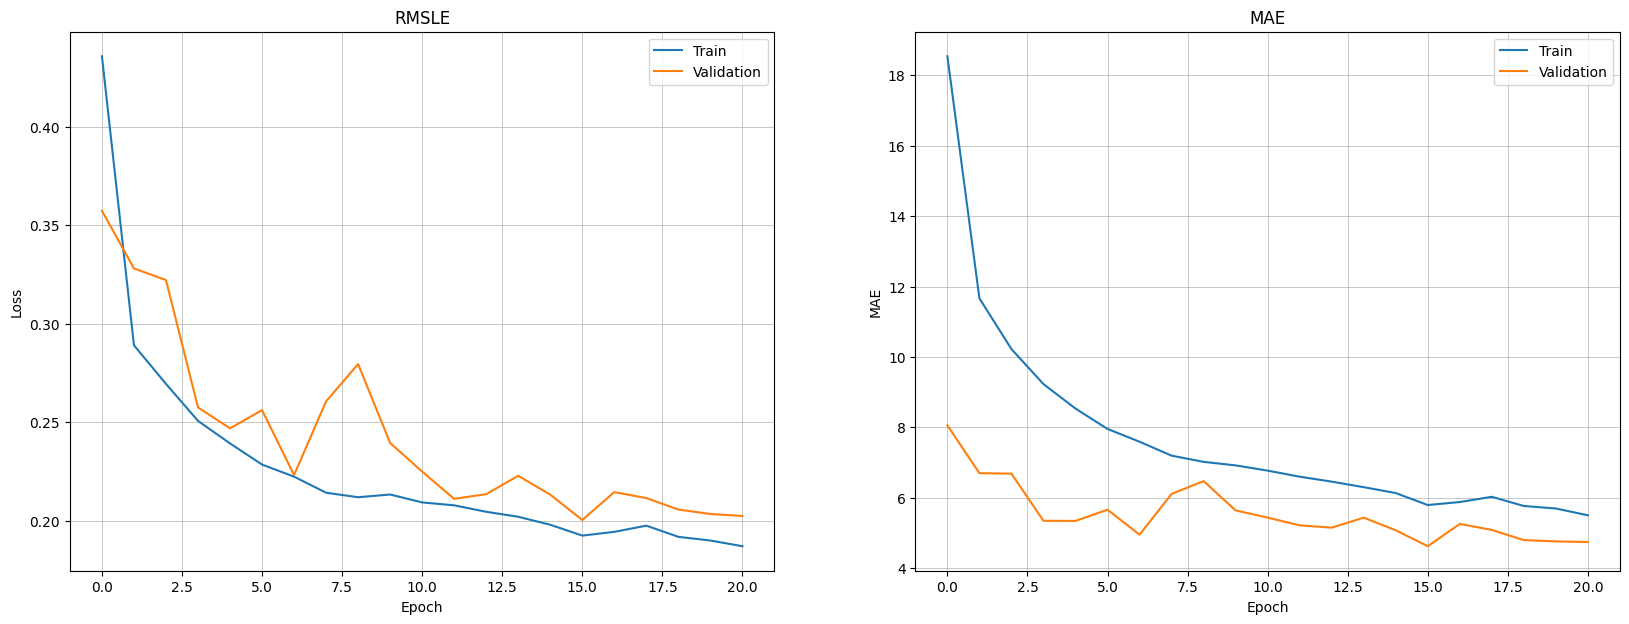

In [64]:
plot_history(history);

In [70]:
model.save('./models/2023-06-13_14:54_rnn')

# Cross-Validation

In [ ]:
def cross_validate_baseline_and_lstm(data: pd.DataFrame):
    '''
    This function cross-validates
    - the "last seen value" baseline model
    - the RNN model
    '''

    #list_of_mae_baseline_model = []
    list_of_mse_recurrent_model = []
    hist = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(data, FOLD_LENGTH, FOLD_STRIDE)

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

        X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        #X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
        #X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

        # 2 - Modelling
        # =========================================

        ##### Baseline Model
        #baseline_model = init_baseline()
        #mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
        #list_of_mae_baseline_model.append(mae_baseline)
        #print("-"*50)
        #print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "loss",
                           mode = "min",
                           patience = 5,
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        hist.append(history)
        res = model.evaluate(X_test, y_test, verbose=0)
        mse_lstm = res[1]
        list_of_mse_recurrent_model.append(mse_lstm)
        print(f"MSE LSTM fold n°{fold_id} = {round(mse_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        #print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    #return list_of_mae_baseline_model, list_of_mae_recurrent_model
    return list_of_mse_recurrent_model, hist

In [ ]:
mses, histories = cross_validate_baseline_and_lstm(data)

# Evaluation

In [ ]:
data_eval = pd.read_csv('./eval_data_for_rnn.csv')
data_eval.head()

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,is_holiday,is_weekend,hour_sin,hour_cos,month_sin,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,0.421634,0.909091,0.397770,0.288608,0.0,0.066987,0.750000,0.5,1.0,0.5,...,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.419426,0.870130,0.388476,0.339241,0.0,0.146447,0.853553,0.5,1.0,0.5,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.419426,0.857143,0.379182,0.410127,0.0,0.250000,0.933013,0.5,1.0,0.5,...,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.417219,0.857143,0.386617,0.334177,0.0,0.370590,0.982963,0.5,1.0,0.5,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.415011,0.870130,0.382900,0.356962,0.0,0.500000,1.000000,0.5,1.0,0.5,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
X = pd.read_csv('./data/X_processed_from_2019_to_2022.csv')
y = pd.read_csv('./data/y_processed_from_2019_to_2022.csv')
data = pd.concat([X,y], axis=1)
data_eval = data.loc[35064*0.75+1:].reset_index().drop(columns=["Unnamed: 0", "index"])

In [ ]:
drop_cols = ['Aubing-Lochhausen-Langwied', 'Harlaching', 'Südgiesing', 'Hasenbergl-Lerchenau Ost', 'Obermenzing', 'Feldmoching',
             'Untermenzing-Allach', 'Lochhausen']

In [ ]:
data_eval.drop(columns=drop_cols, inplace=True)
data_eval.columns

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data[districts])
data_eval_scaled = data_eval.copy()
data_eval_scaled[districts] = scaler.transform(data_eval[districts])
data_eval_scaled.head()

,is_holiday,is_weekend,temperature_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,1.0,1.0,0.445916,0.434944,0.174684,0.0,0.066987,0.750000,0.75,0.933013,...,0.007345,-0.537429,0.691203,-0.316127,-0.477888,-0.427852,-0.427852,-0.728863,-0.728863,-0.12326
1,1.0,1.0,0.419426,0.410781,0.164557,0.0,0.146447,0.853553,0.75,0.933013,...,-0.402759,-0.281638,-0.736228,-0.316127,-0.477888,-0.427852,-0.427852,-0.728863,-0.728863,-0.12326
2,1.0,1.0,0.388521,0.379182,0.164557,0.0,0.250000,0.933013,0.75,0.933013,...,0.007345,-0.281638,-0.260417,2.245622,-0.477888,-0.427852,-0.427852,-0.728863,-0.728863,-0.12326
3,1.0,1.0,0.379691,0.366171,0.205063,0.0,0.370590,0.982963,0.75,0.933013,...,0.007345,-0.793220,-0.736228,-0.316127,-0.477888,-0.427852,-0.427852,-0.728863,-0.728863,-0.12326
4,1.0,1.0,0.355408,0.342007,0.215190,0.0,0.500000,1.000000,0.75,0.933013,...,-0.402759,-0.537429,-0.736228,-0.316127,-0.477888,-0.427852,-0.427852,-0.728863,-0.728863,-0.12326


In [67]:
# create sequences of X and y_true for evaluation
X_eval, y_true = [], []

for i in range(0,len(data_eval)-INPUT_LENGTH-OUTPUT_LENGTH,OUTPUT_LENGTH):
    Xi = data_eval_scaled.loc[i:i+INPUT_LENGTH-1]
    yi = data_eval[i+INPUT_LENGTH:i+INPUT_LENGTH+OUTPUT_LENGTH][districts]
    X_eval.append(Xi.to_numpy())
    y_true.append(yi.to_numpy())


In [68]:
X_eval = np.array(X_eval)
y_true = np.array(y_true)
print(f'X_eval: {X_eval.shape}, y_true: {y_true.shape}')

X_eval: (351, 336, 48), y_true: (351, 24, 34)


## Evaluation Score

In [69]:
model.evaluate(X_eval, y_true)

11/11 [==============================] - 0s 21ms/step - loss: 0.3449 - mse: 12.0745


[0.34489428997039795, 12.07452392578125]

In [115]:
np.sqrt(0.345)

0.5873670062235365

In [ ]:
np.sqrt(16.3)

4.03732584763727

In [117]:
y_pred = model.predict(X_eval)
y_pred.shape

11/11 [==============================] - 0s 22ms/step


(351, 24, 34)

In [74]:
X_eval.shape

(351, 336, 48)

In [75]:
from sklearn.metrics import r2_score

r2_score(np.reshape(y_true, (286416,1)), np.reshape(y_pred, (286416,1)))

0.48419676697956204

In [118]:
y_pred_reshape = [x if x >= 0 else 0 for x in np.reshape(y_pred, (286416,1))]

In [121]:
r2_score(np.reshape(y_true, (286416,1)), y_pred_reshape)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


0.4876937469628623

In [127]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(np.reshape(y_true, (286416,1)), np.array(y_pred_reshape))

<ipython-input-127-5be98baaf47e>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_squared_log_error(np.reshape(y_true, (286416,1)), np.array(y_pred_reshape))


0.3448942919455922

In [76]:
y_df = []
for i in range(y_pred.shape[0]):
  y_df.append(pd.DataFrame(y_pred[i], columns=districts))

In [77]:
y_pred_total = pd.concat(y_df, axis=0).reset_index().drop(columns='index')
y_pred_total.shape

(8424, 34)

In [78]:
y_true_total = data_eval[INPUT_LENGTH:-5][districts].reset_index().drop(columns='index')

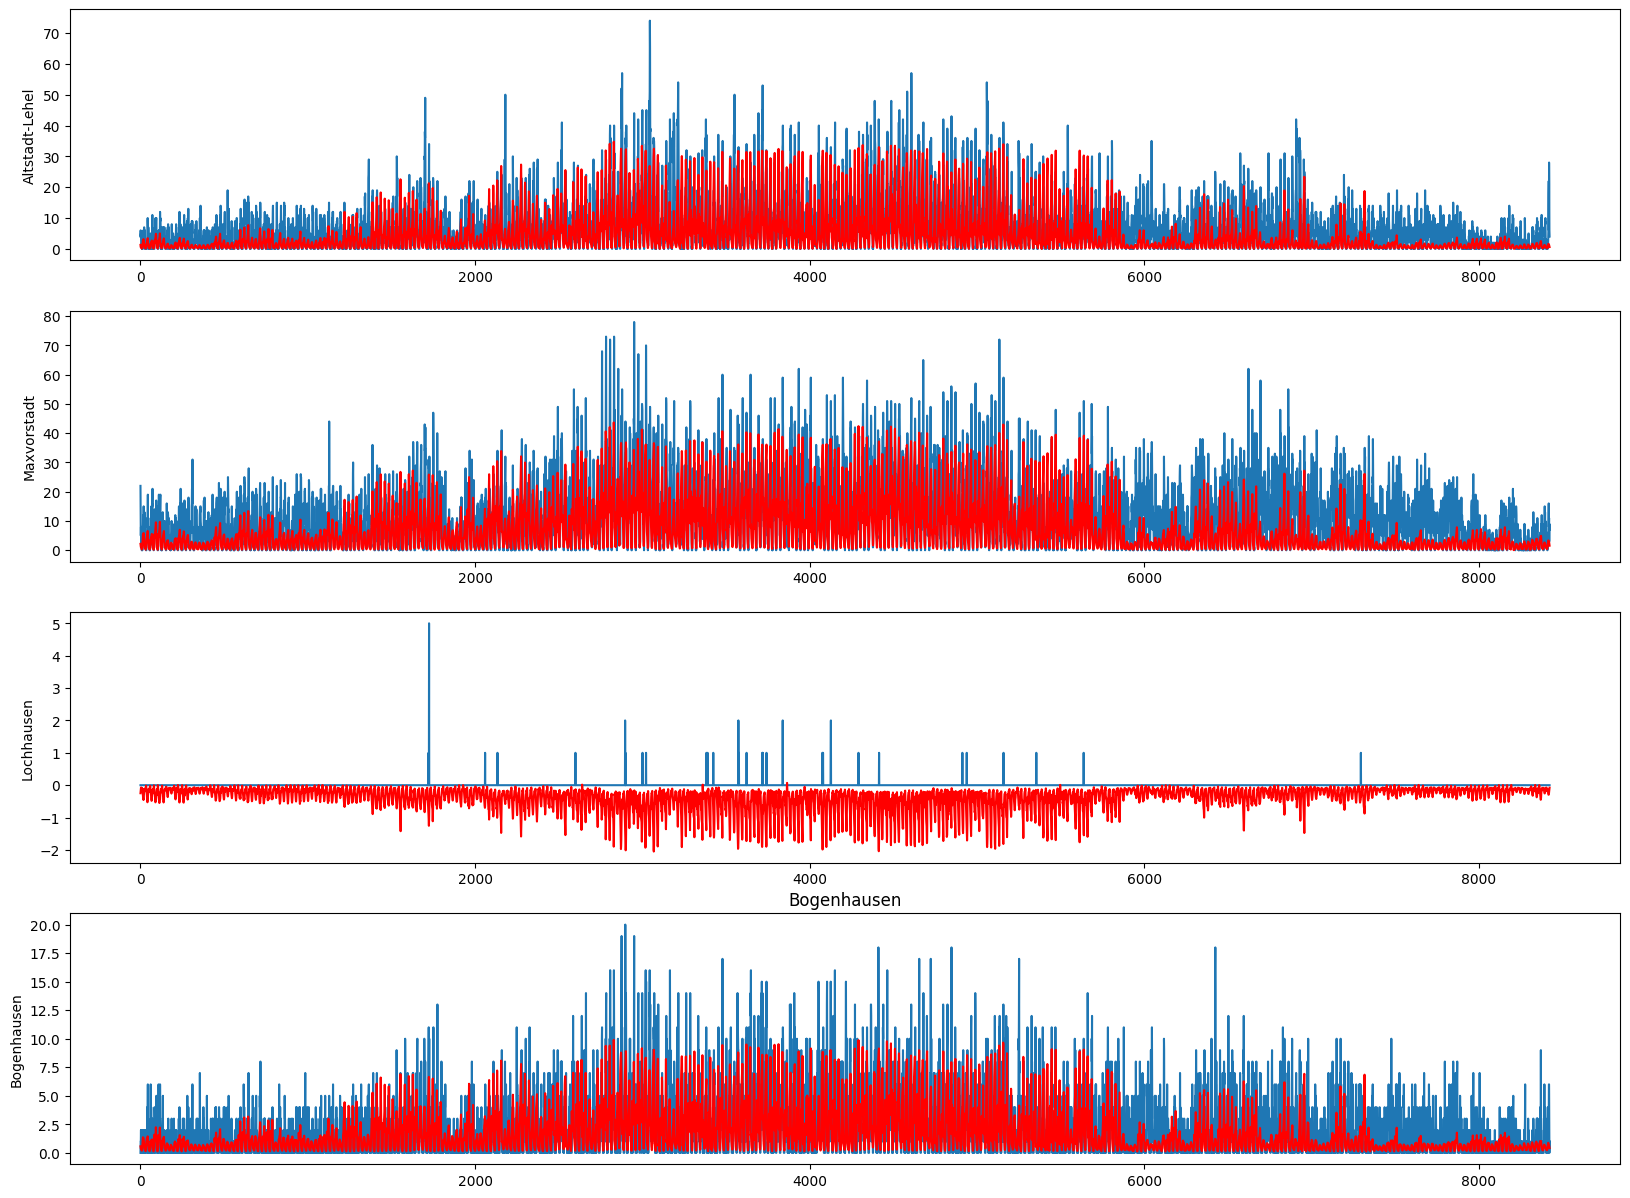

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4,1, figsize=(20,15))
districts=['Altstadt-Lehel', 'Maxvorstadt', 'Lochhausen', 'Bogenhausen']
for i in range(4):
  sns.lineplot(x=y_true_total.index, y=districts[i], data=y_true_total, ax=ax[i])
  sns.lineplot(x=y_pred_total.index, y=districts[i], data=y_pred_total, ax=ax[i], color='red')
  plt.title(districts[i])

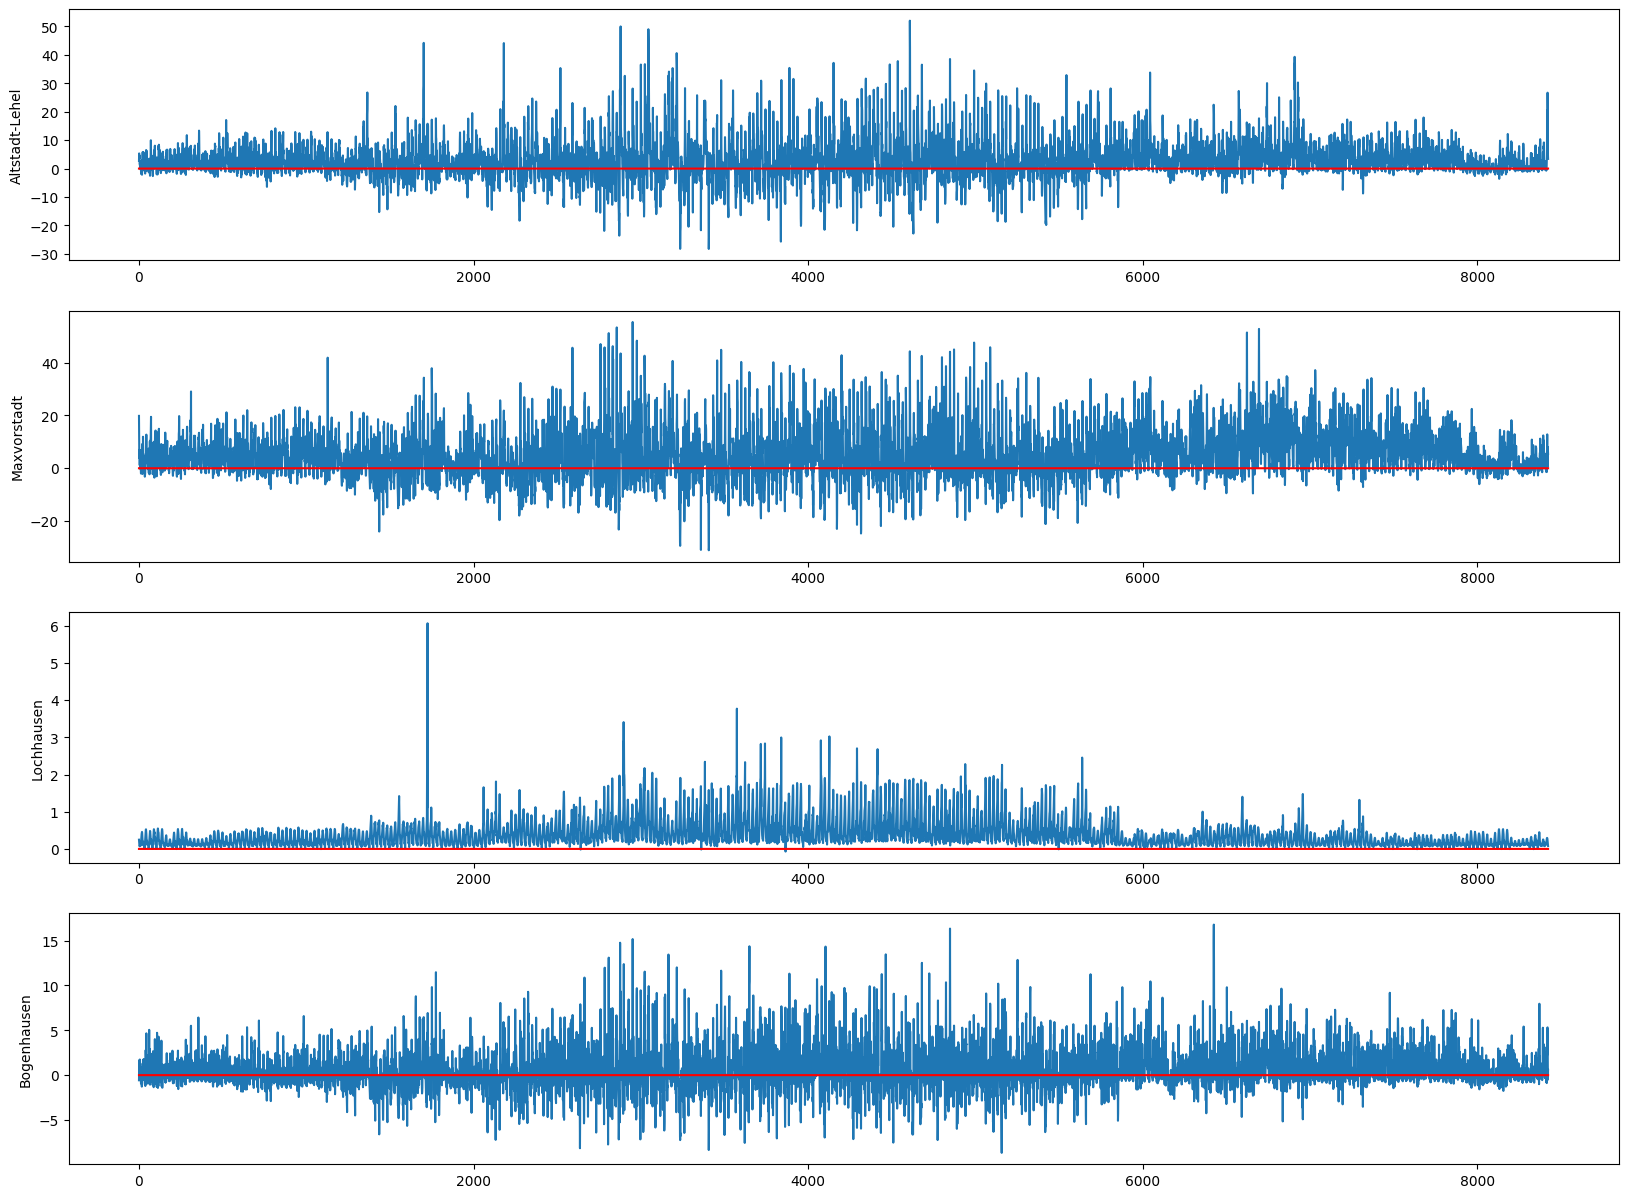

In [80]:
fig, ax = plt.subplots(4,1, figsize=(20,15))
for i in range(4):
  residuals = y_true_total[[districts[i]]] - y_pred_total[[districts[i]]]
  sns.lineplot(x=residuals.index, y=districts[i], data=residuals, ax=ax[i])
  sns.lineplot(x=residuals.index, y=0, data=residuals, ax=ax[i], color='red');

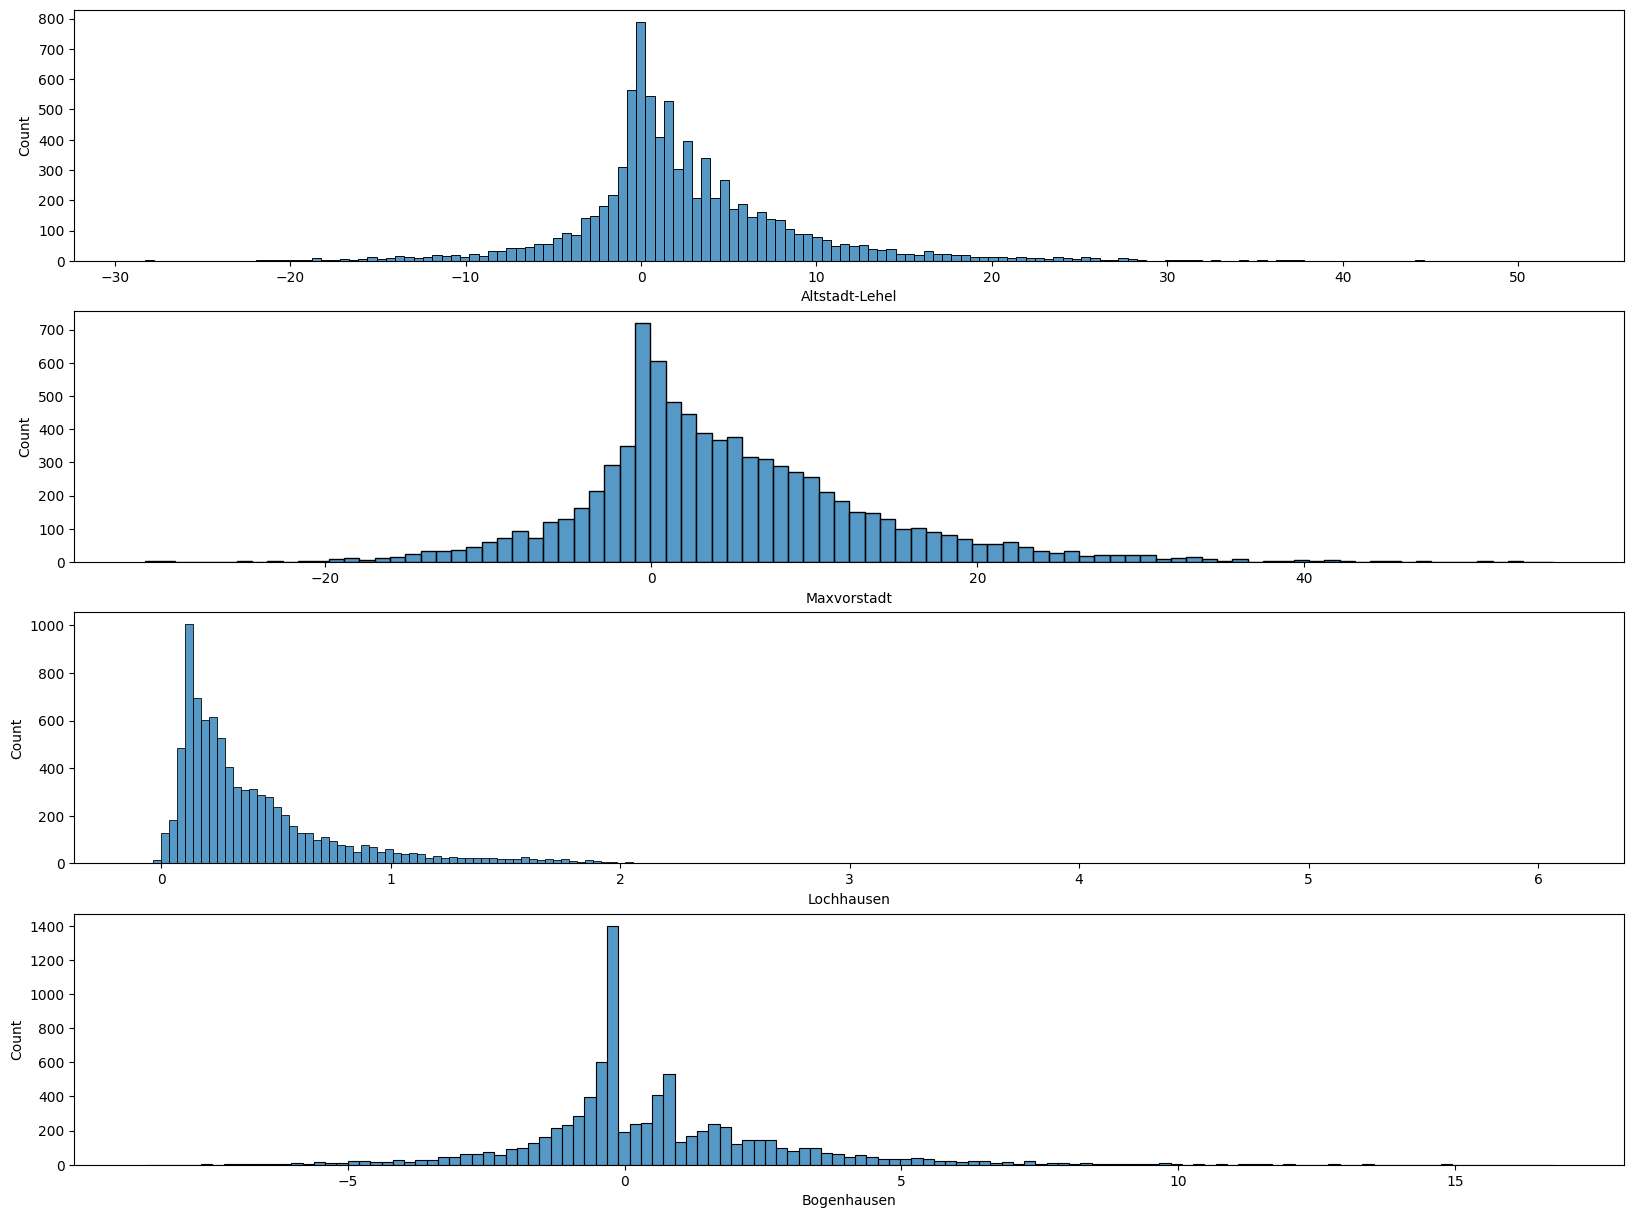

In [81]:
fig, ax = plt.subplots(4,1, figsize=(20,15))
for i in range(4):
  residuals = y_true_total[[districts[i]]] - y_pred_total[[districts[i]]]
  sns.histplot(x=districts[i], data=residuals, ax=ax[i])
  #sns.lineplot(x=residuals.index, y=0, data=residuals, ax=ax[i], color='red');

# Visualization of Results

In [83]:
y_true.shape

(351, 24, 34)

In [84]:
y_pred.shape

(351, 24, 34)

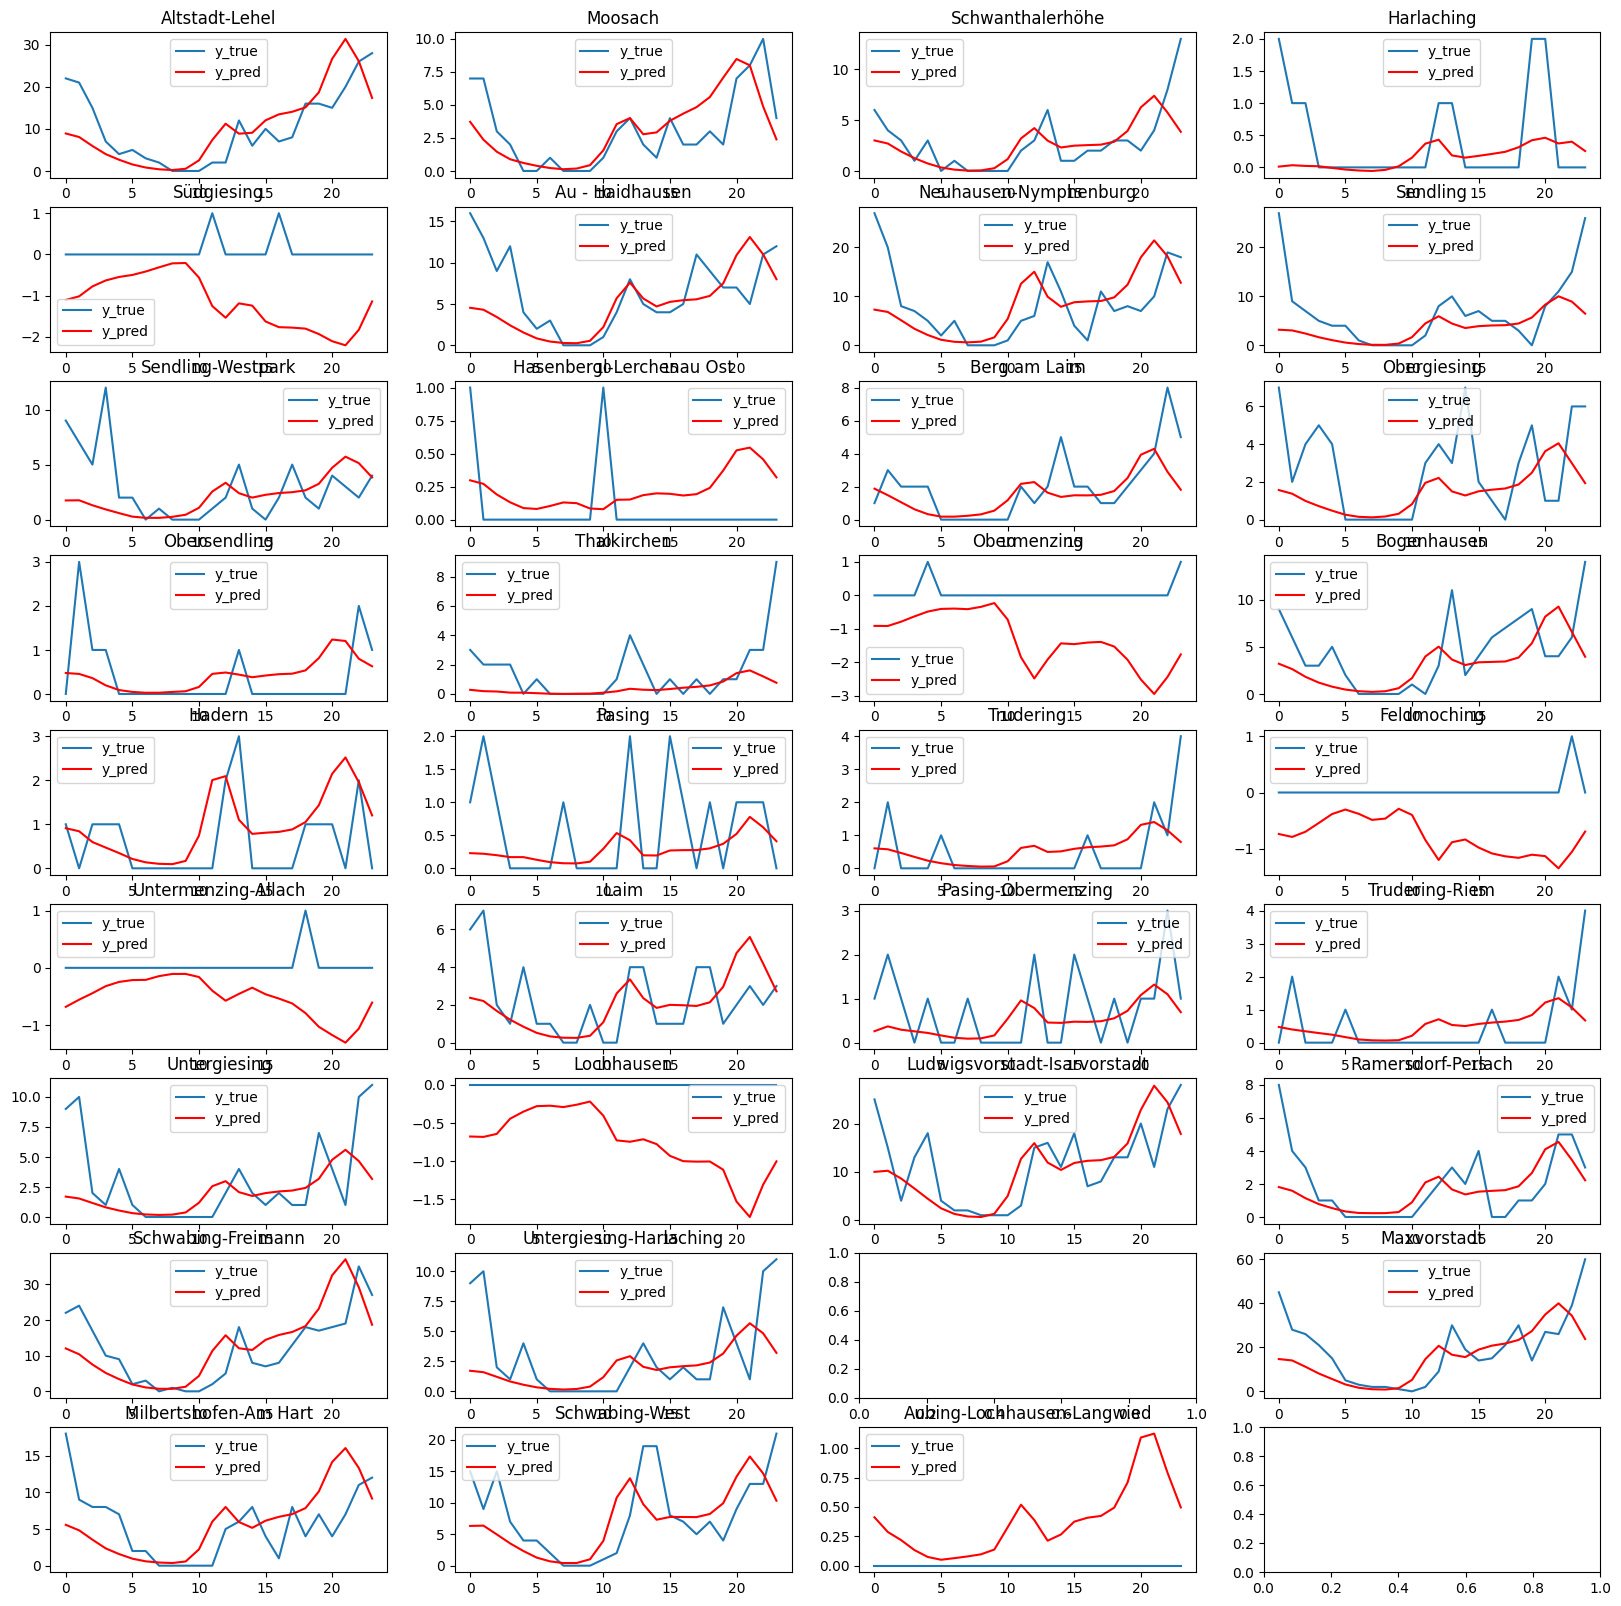

In [114]:
fig, ax = plt.subplots(9,4, figsize=(20,20))
for i in range(y_pred.shape[2]):
  row = i % 9
  col = i % 4
  ax[row][col].plot(y_true[151,:,i], label='y_true')
  ax[row][col].plot(y_pred[151,:,i], label='y_pred', color='red')
  ax[row][col].set_title(districts[i])
  ax[row][col].legend();

In [98]:
6%4

2